In [1]:
# Set filetype environment variable here, before anything is loaded... "LSM" is LSM, "CV" is default and for CV7000 or CV8000
import os
os.environ["FILE_TYPE"] = "LSM"

In [3]:
#import some tools that we will use
import json
import skimage.io
import skimage.measure
import skimage.feature
import skimage.segmentation
from skimage.morphology import disk
import scipy.ndimage
import numpy
import matplotlib.pyplot as plt
from generate_spot_positions import GenerateSpotPositionsJob
from models.image_filename_glob import ImageFilenameGlob
from models.generate_spot_positions_config import GenerateSpotPositionsConfig
import csv
import scipy.ndimage
from pathlib import Path

In [13]:
#define paths to images
image_folder = "/data/finne/20210723_Josh/Results/cell_crops/"

well_ID = "DMSO6hrTreatment"
field_ID = 3
channel_ID = 1

# Pick out 10 nuclei (glob orders them randomly)
image_path = Path(image_folder)

image_filename_glob = image_path.rglob(str(ImageFilenameGlob(well = well_ID, f = field_ID, c = channel_ID, suffix="_maximum_projection_nuclear_mask_???", extension="npy")))

images_selected_C2 = [next(image_filename_glob) for _ in range(10)]

for image_selected in images_selected_C2:
    print(image_selected)

/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_034.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_012.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_010.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_017.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_033.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_003.npy
/data/finne/20210723_Josh/Results/cell_crops/TIFs/DMSO6hrTreatment_2021_07_14__12_03_10/p3/ch1/zXX_maximum_projection_nuclear_mask_025.npy
/data/finne/20210723_Josh/R

In [14]:
# SET PARAMETERS HERE! 

# Contrast threshold is applied to the laplacian of the gaussian, it is fairly cryptic, so trial and error works best to find a good value.
local_contrast_threshold = 2.4

# Peak radius is applied to pre-filter the spots; anything smaller than this will get filtered out, so err on the small side. 
# It ought to be near the actual radius of the visible spot in pixels, though.
peak_radius = 2

# Because your images are normalized to 0-1 range in the cell, your spot maxima are set to 1. So this ought to be the inverse of your overall signal:noise ratio
# Counterintuitively, better FISH -> lower threshold here -> less filtering taking place on the actual image
global_contrast_threshold = 0.6

segmenters = [GenerateSpotPositionsJob(image, "no_output", image_folder, local_contrast_threshold, peak_radius, global_contrast_threshold) for image in images_selected_C2]

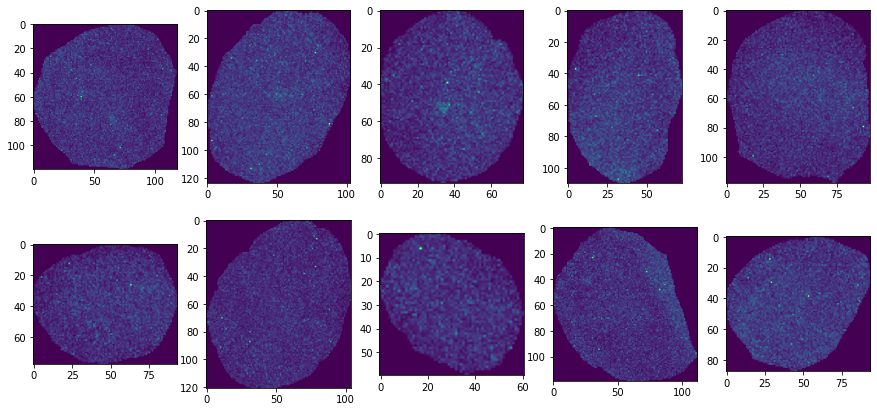

In [15]:
# display image and found spots -- these coordinates (+ offset) can be used to look up precalculated z-position and radial position. 

fig, axs = plt.subplots(2,5)

for i in range(0,10):
    ax = axs[i//5, i%5]
    ax.imshow(segmenters[i].image)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    for spot in segmenters[i].spots:
        circle=plt.Circle((spot[1], spot[0]), 7, color='r', alpha=0.3)
        ax.add_patch(circle)
        #ax.text(x = spot[1]-20, y = spot[0]-15, s = "%.2f, %.2f"%(spot[1], spot[0]), bbox=dict(fill=True))

fig.set_size_inches(15,7)
fig.canvas.draw()

In [16]:

# read in config file into hash
# change hash as needed to reflect parameters above
# overwrite config file with new values
# YOU WILL NEED TO RUN THIS THREE TIMES TO GET PARAMETERS FOR EACH CHANNEL!

config_file = "/data/finne/20210723_Josh/Results/cell_crops/spot_seg_config.json"

config_file_path = Path(config_file)

existing_generate_spot_positions_configs = []
if config_file_path.exists():
    with open(config_file_path) as json_file:
        existing_generate_spot_positions_configs_json_params = json.load(json_file)
        existing_generate_spot_positions_configs = [
            GenerateSpotPositionsConfig.from_json_params(json_params)
            for json_params
            in existing_generate_spot_positions_configs_json_params
        ]

current_generate_spot_positions_config = GenerateSpotPositionsConfig(
    channel=channel_ID,
    local_contrast_threshold=local_contrast_threshold,
    peak_radius=peak_radius,
    global_contrast_threshold=global_contrast_threshold
)

updated_generate_spot_positions_configs = [
    current_generate_spot_positions_config,
    *(
        existing_generate_spot_positions_config
        for existing_generate_spot_positions_config
        in existing_generate_spot_positions_configs
        if existing_generate_spot_positions_config.channel != current_generate_spot_positions_config.channel
    )
]

updated_generate_spot_positions_configs_json_params = [config.to_json_params() for config in updated_generate_spot_positions_configs]
with open(config_file_path, 'w') as write_file:
    json.dump(updated_generate_spot_positions_configs_json_params, write_file)
